## Guess the Elo

Guess the Elo is a significant source of entertainment in online chess content. Content creators analyze entire chess games without knowledge of the players' ratings. They then attempt to guess the Elo based on various factors such as the players' ability to spot tricks, defend and attack effectively, and avoid blunders.

In this project, I will take a slightly different approach by using a Convolutional Neural Network (CNN) to predict the Elo rating of chess players based on a single chess position. This will be achieved by utilizing the dataset collected in previous notebooks and training the CNN on them.

The dataset provides information on moves and both players' Elo ratings. The players' ratings will serve as the target variable, and each state of the moves list will be considered an input feature.

As the dataset is not yet in a suitable format for immediate use with a CNN, several preprocessing steps are required to adequately prepare the data.

## Preprocessing

As you will observe later, there will be a notable increase in the dataset previously collected. Initially, each row of the dataframe, representing a game, will be replicated N times, with N representing the number of moves in the game. Following that, each entry will be doubled again to represent each state of the game for a single player, each with their individual rating. The `chess` library will be employed to represent a chess state.

Because of these adjustments, only a small fraction of the dataset will be used for illustrative purposes. Let's proceed by loading the dataset and sampling 1000 data points. Additionally, columns that are not useful for network training are going to be deleted.

In [4]:
import pandas as pd
import chess
import re
from typing import List
import numpy as np
from itertools import product
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
from statistics import fmean
#seed for reproducibility
np.random.seed(123)

chess_data = pd.read_csv('chess_data.csv', header=0, sep=';')
chess_data.dropna(subset=['moves', 'white_country', 'black_country', 'ECO_URL'], inplace=True)
chess_data = chess_data.sample(n=1000, random_state=123)
chess_data = chess_data[['white_elo', 'black_elo', 'moves']]
chess_data

,white_elo,black_elo,moves
608409,1200,1519,1. g4 b6 2. h4 Bb7 3. Bg2 Bxg2 4. e3 Bxh1 5. N...
629472,999,971,1. d4 { [%clk 0:09:59.6] } 1... d5 { [%clk 0:0...
853260,999,1601,1. b4 { [%clk 0:29:57.2] } 1... Nf6 { [%clk 0:...
737019,1486,1554,1. d4 { [%clk 0:10:00] } 1... b6 { [%clk 0:09:...
669226,1081,1275,1. e4 { [%clk 0:15:00] } 1... e6 { [%clk 0:15:...
...,...,...,...
465069,990,862,1. e4 { [%clk 0:03:02] } 1... g6 { [%clk 0:02:...
137207,697,697,1. e4 { [%clk 0:09:59.9] } 1... d5 { [%clk 0:0...
326121,441,829,1. e4 { [%clk 0:10:00] } 1... e5 { [%clk 0:10:...
223425,675,637,1. e4 { [%clk 0:10:00] } 1... e5 { [%clk 0:09:...


In order to replicate each move of the game as explained before, let's clean the string value in `moves` and then replicate each move to its respective row.

In [5]:
def clean_moves(moves: str) -> List[str]:
    states = []
    board = chess.Board()
    states = [board.__str__().replace("\n", " ")]
    # Remove clock info
    moves = re.sub(r' {[^}]*}', '', moves)
    # Remove moves indexes
    moves = [item for item in moves.split() if not item[0].isdigit()]
    for move in moves:
        try:
            board.push_san(move)
        except ValueError as e:
            return []
        states.append(board.__str__().replace("\n", " "))
    return states

chess_data['moves'] = chess_data['moves'].apply(clean_moves)
# In case a move was set as invalid by the chess lib, remove the data
chess_data = chess_data[chess_data['moves'].apply(lambda x: x != [])]
chess_data = chess_data.explode('moves')
chess_data = pd.concat([pd.DataFrame({'elo': chess_data['white_elo'], 'moves': chess_data['moves']}),
                 pd.DataFrame({'elo': chess_data['black_elo'], 'moves': chess_data['moves']})],
                ignore_index=True)
chess_data

,elo,moves
0,1200,r n b q k b n r p p p p p p p p . . . . . . . ...
1,1200,r n b q k b n r p p p p p p p p . . . . . . . ...
2,1200,r n b q k b n r p . p p p p p p . p . . . . . ...
3,1200,r n b q k b n r p . p p p p p p . p . . . . . ...
4,1200,r n . q k b n r p b p p p p p p . p . . . . . ...
...,...,...
121629,796,. . . . . . . . . . . . . . . K . . . . . . . ...
121630,796,. . . . . . . . . . . . . . . K . . . . . . . ...
121631,796,. . . . . . . . . . . . . . . K . . . . . . . ...
121632,796,. . . . . . . . . . . . . . . K . . . . . . . ...


Because a CNN is being used, let's split the game state into different channels, one for each chess piece. This allows the network to focus on learning features specific to each piece, instead of trying to learn patterns from all the pieces at once. Therefore, for each game state we collected in previous steps, it will generate six 8x8 matrices, one for each chess piece: Pawns (p/P), Bishops (b/P), Knights (n/N), Rooks (r/R), Queens (q/Q), and Kings (k/K). A piece is represented as `+1` if white (uppercase letters), `-1` if black pieces (lowercase letters), and `0` if this specific piece is not present in that square. Finally, these channels will be transformed into NumPy arrays for them to be fed as input to the network.

In [6]:
def extract_channels(board_list: List[str]) -> List[List[int]]:
    pieces = [['p', 'P'], ['b', 'B'], ['n', 'N'], ['r', 'R'], ['q', 'Q'], ['k', 'K']]
    channels = []
    for piece in pieces:
        channel = []
        for elem in board_list:
            if elem == ' ':
                continue
            if elem == piece[0]:
                channel.append(-1)
            elif elem == piece[1]:
                channel.append(1)
            else:
                channel.append(0)
        channels.append(channel)
    return channels

chess_data['moves'] = chess_data['moves'].apply(extract_channels)
chess_data['moves'] = chess_data['moves'].apply(lambda x: np.array(x).reshape(6, 8, 8))
chess_data

,elo,moves
0,1200,"[[[0, 0, 0, 0, 0, 0, 0, 0], [-1, -1, -1, -1, -..."
1,1200,"[[[0, 0, 0, 0, 0, 0, 0, 0], [-1, -1, -1, -1, -..."
2,1200,"[[[0, 0, 0, 0, 0, 0, 0, 0], [-1, 0, -1, -1, -1..."
3,1200,"[[[0, 0, 0, 0, 0, 0, 0, 0], [-1, 0, -1, -1, -1..."
4,1200,"[[[0, 0, 0, 0, 0, 0, 0, 0], [-1, 0, -1, -1, -1..."
...,...,...
121629,796,"[[[0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0,..."
121630,796,"[[[0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0,..."
121631,796,"[[[0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0,..."
121632,796,"[[[0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0,..."


# Model

Because fine-tuning the hyperparameters of a model for large datasets is computationally expensive, I will use the previously collected sample. I will split this sample dataset into training, validation, and test sets using an 80-10-10 split. To achieve this, sklearn's `train_test_split` will be used. Additionally, I will apply stratified sampling to ensure that all sets exhibit similar distributions with respect to the target data values. Notice that I'm using stratified sampling only when splitting the validation and test sets. This is necessary because train_test_split throws an exception when the least populated label lacks at least two instances for proper splitting, a scenario present in this small sample dataset. In the original dataset, stratified sampling ideally should be used in both steps.

In [4]:
X = np.stack(chess_data['moves'])
y = np.stack(chess_data['elo'])
X_train, X_validation_test, y_train, y_validation_test = train_test_split(X, y, test_size=0.2, stratify=y)
X_validation, X_test, y_validation, y_test = train_test_split(X_validation_test, y_validation_test, test_size=0.5)

Our base CNN model is really simple, consisting of two convolutional layers and, at the end, a linear activation function, as we're dealing with a regression problem. To obtain the best estimates for a metric based on the validation set, I will create several versions of our base model with different configurations, including dropout and max-pooling, and varying the number of epochs. Whichever version of this model provides the best estimates for the metric based on the validation set will be used for the original dataset.

In [5]:
def create_model(_, use_pooling, use_dropout):
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(6, 8, 8)))
    if use_pooling:
        model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(64, (2, 2), activation='relu'))
    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    if use_dropout:
        model.add(Dropout(0.1))
    model.add(Dense(1, activation='linear'))
    return model

epochs = [10, 25, 50]
use_dropout = [True, False]
use_pooling = [True, False]

all_combinations = list(product(epochs, use_pooling, use_dropout))
all_results = []
best_mae = 0
best_model = None

for combination in all_combinations:
    print('Evaluating model... Epoch:', combination[0], 'Pooling:', combination[1], 'Dropout:', combination[2])
    model = create_model(*combination)
    model.compile(optimizer='adam', loss=tf.keras.losses.MeanSquaredError(), metrics=['mae'])
    model.fit(X_train, y_train, epochs=combination[0], verbose=0)
    loss, mae = model.evaluate(X_validation, y_validation, verbose=0)
    all_results.append([combination, loss, mae])
    print('Loss:', loss, 'MAE:', mae, '\n')
    if best_model is None:
        best_model = model
        best_mae = mae
    elif mae >= best_mae:
        best_model = model
        best_mae = mae


Evaluating model... Epoch: 10 Pooling: True Dropout: True
Loss: 89545.4140625 MAE: 236.7811737060547 

Evaluating model... Epoch: 10 Pooling: True Dropout: False
Loss: 88100.234375 MAE: 234.0190887451172 

Evaluating model... Epoch: 10 Pooling: False Dropout: True
Loss: 83924.9375 MAE: 228.55728149414062 

Evaluating model... Epoch: 10 Pooling: False Dropout: False
Loss: 82618.8359375 MAE: 225.5817413330078 

Evaluating model... Epoch: 25 Pooling: True Dropout: True
Loss: 75787.3359375 MAE: 216.0697784423828 

Evaluating model... Epoch: 25 Pooling: True Dropout: False
Loss: 74293.2109375 MAE: 213.22439575195312 

Evaluating model... Epoch: 25 Pooling: False Dropout: True
Loss: 59135.63671875 MAE: 186.68739318847656 

Evaluating model... Epoch: 25 Pooling: False Dropout: False
Loss: 57015.109375 MAE: 181.22500610351562 

Evaluating model... Epoch: 50 Pooling: True Dropout: True
Loss: 60498.1171875 MAE: 188.32823181152344 

Evaluating model... Epoch: 50 Pooling: True Dropout: False
Loss:

A few expected results: as the number of epochs increases, the network is able to extract more patterns and information from the training data. Networks with a pooling layer consistently underperform when compared to their counterparts in this problem. This is because our input is already small enough (six channels of size 8x8); therefore, the information loss is noticeable. Regarding the dropout layer, there doesn't seem to be much impact when analyzing our metric (Mean Absolute Error).

Since we trained using only a small portion of the original dataset, we will include a dropout layer in our real training, as it is likely to be helpful due to the dataset's size.

# Trained model

Because the training of the network with our huge dataset (after all the preprocessing described in the `data_collection` notebook and the ones described here, which increase its size tremendously) would take a long time, especially running 50 epochs as we previously determined, the training was not done on this notebook.

Let's import the weights of the trained network:

In [5]:
trained_model = tf.keras.models.load_model('trained_weights.keras')
trained_model.compile(optimizer='adam', loss=tf.keras.losses.MeanSquaredError(), metrics=['mae'])

Let's assess how this model performs using the test dataset, which will be imported locally. Due to the its size, this test dataset will not be provided. However, the original dataset is available, and you, as the user, are welcome to apply all the preprocessing steps described earlier. The same dataset should be generated in the same way as mine.

The test dataset will be read in batches to avoid exhausting my machine's memory. Additionally, the predictions made by the network are going to be stored to manually calculate the metric (Mean Absolute Error), this is done to thoroughly analyze the model's performance.

It's important to notice that I am only now applying the preprocessing methods `extract_channels` and reshaping and casting the data into NumPy arrays. This was done to avoid storing a large file on my hard disk, as the two methods discussed earlier significantly increase disk memory usage. The same approach was taken during training.

In [6]:
chunk_size = 1500000
preds_labels = []
for chess_data in pd.read_csv('test_data.csv', chunksize=chunk_size, sep=';'):
        chess_data['moves'] = chess_data['moves'].apply(extract_channels)
        chess_data['moves'] = chess_data['moves'].apply(lambda x: np.array(x).reshape(6, 8, 8))

        X = np.stack(chess_data['moves'])
        y = np.stack(chess_data['elo'])

        pred = trained_model.predict(X, verbose=1)
        preds_labels.append((pred, y,))

9979/9979 [==============================] - 18s 2ms/step


Let's calculate the overall performance of the model. Again, the metric used was MAE, which is generally used for regression problems that measures the average absolute difference between the label and the predicted values.

In [7]:
predictions = []
labels = []
for pred_lable in preds_labels:
    predictions.append(pred_lable[0])
    labels.append(pred_lable[1])
predictions = np.concatenate(predictions, axis=0)
labels = np.concatenate(labels, axis=0)

mean_absolute_error(predictions, labels)

279.67062593553965

Let's now analyze the network's performance to specific elo ranges.

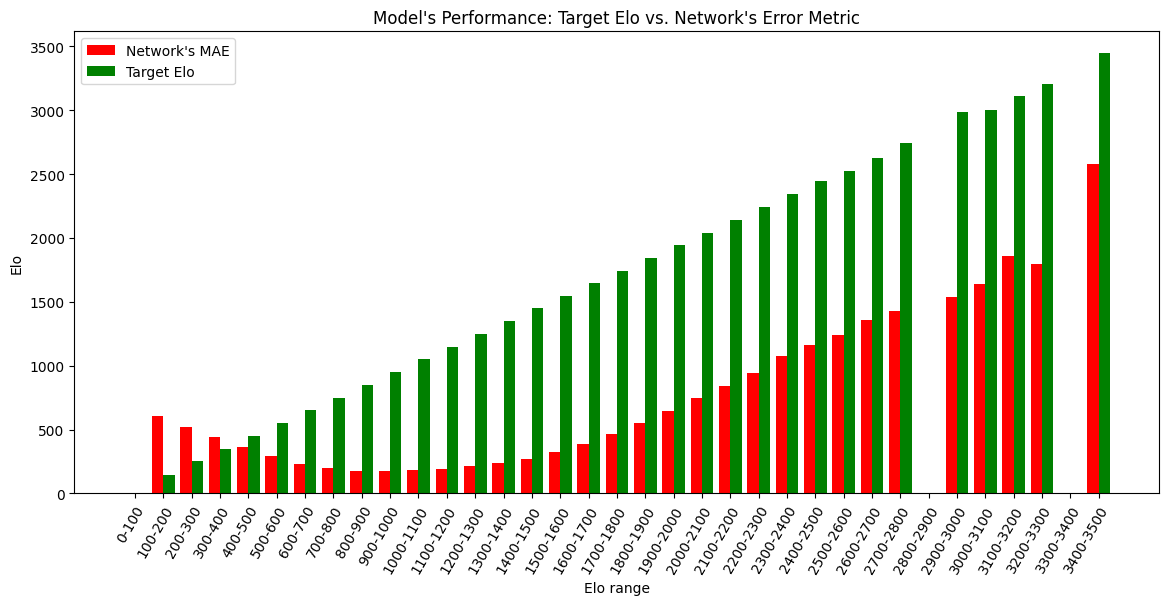

In [64]:
predictions_by_elo = {}
labels_by_elo = {}
for i in range(0, 3500, 100):
    predictions_by_elo[i] = []
    labels_by_elo[i] = []

for i in range(len(labels)):
    for j in range(0, 3500, 100):
        if j <= labels[i] < j+100:
            predictions_by_elo[j].append(predictions[i])
            labels_by_elo[j].append(labels[i])

y_predictions = []
y_label_average = []
for i in range(0, 3500, 100):
    if len(predictions_by_elo[i]) == 0 or len(labels_by_elo[i]) == 0:
        y_predictions.append(0)
        y_label_average.append(0)
    else:
        y_predictions.append(mean_absolute_error(predictions_by_elo[i], labels_by_elo[i]))
        y_label_average.append(fmean(labels_by_elo[i]))


x_labels = [str(i) + '-' + str(i+100) for i in range(0, 3500, 100)]

plt.figure(figsize=(14, 6))
x_ticks = range(len(x_labels))
  
plt.bar(np.arange(len(x_labels)) - 0.2, y_predictions, 0.4, label = "Network's MAE", color='red') 
plt.bar(np.arange(len(x_labels)) + 0.2, y_label_average, 0.4, label = 'Target Elo', color='green') 
  
plt.xticks(x_ticks, x_labels, rotation=60, rotation_mode='anchor', horizontalalignment='right')
plt.xlabel("Elo range") 
plt.ylabel("Elo") 
plt.title("Model's Performance: Target Elo vs. Network's Error Metric") 
plt.legend() 
plt.show() 

# Discussions and Final Considerations

The network's metric (MAE) is `279.7`, indicating that, on average, this model predicted the Elo when observing an unseen chess state within a ± 279.7 error margin. Considering the constraints imposed by the data itself, such as the bias when fetching games from player only in alphanumeric order and the unbalanced dataset in terms of players' Elo, this final result is rather acceptable, given the simplicity of the network's structure.

When analyzing the graph above, we observe a lower degree of error in predictions when the Elo ratings fall within the range of 500 to 1500. This occurs because, as we have seen previously, the majority of the dataset comprises Elo ratings within that range. Consequently, the model tends to learn more features, possibly leading to overfitting, which, in turn, influences the error rate. Additionally, note the significant MAE value for higher Elo ratings (3000 and above). This is a consequence of the limited data available in that rating range, contributing to a higher error rate.

## What could have been done better?



* The primary issue lies in the dataset, despite having a sufficient number of games, especially after preprocessing that increased its size. The dataset, however, remained highly unbalanced, and to the best of my knowledge, circumventing this imbalance was impossible when using chess.com's public API at the time of this writing.
* It's possible that employing a more complex network or adjusting hyperparameters differently could have produced better results for the network. Nevertheless, due to the dataset's size, which consequently increases the learning time, I lack the resources to further explore these alternatives on my machine.
* Normalizing the Elo rating to a value between 0 and 1, for instance, could have helped the network to converge faster during the learning stage.

## A more robust future project

Content creators, when playing Guess the Elo, typically analyze the entire game rather than focusing solely on a single state to make an informed guess about the player's Elo rating. While this wasn't the initial objective of our project, it would be interesting to consider feeding the entire game to a neural network instead of just one state.

Several important changes would need to be implemented compared to the current approach. This includes incorporating a larger number of games and ensuring a more balanced dataset, preferably sourced from a diverse pool of players to reduce bias. More significantly, since chess is inherently a sequential game where every move, whether it's the first or the last, can provide crucial information about the player's rating, it is plausible that using a recurrent neural network, such as LSTM (Long Short-Term Memory), could yield promising results.